# Building a Neural Network from scratch

**Dataset** - A CSV file containing patients medical records and the likelihood of being diabetic.

**Number of records**: 768

**Number of features**: 8

**Features include:**
- `preg` - Number of times pregnant
- `plas` - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- `pres` - Diastolic blood pressure (mm Hg)
- `skin` - Triceps skin fold thickness (mm)
- `test` - 2-Hour serum insulin (mu U/ml)
- `mass` - Body mass index (weight in kg/(height in m)^2)
- `pedi` - Diabetes pedigree function
- `age` - Age (years)

**And the target class**
- `class` - Class variable (`1`:tested positive for diabetes, `0`: tested negative for diabetes)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from pdb import set_trace
import pandas as pd

In [2]:
data_path = './pima.csv'
data = pd.read_csv(data_path)

In [3]:
data.head(10)

,preg,plas,pres,skin,test,mass,pedi,age,class
0,14,175,62,30,0,33.6,0.212,38,1
1,7,133,88,15,155,32.4,0.262,37,0
2,4,146,78,0,0,38.5,0.520,67,1
3,15,136,70,32,110,37.1,0.153,43,1
4,3,107,62,13,48,22.9,0.678,23,1
5,3,169,74,19,125,29.9,0.268,31,1
6,5,116,74,29,0,32.3,0.660,35,1
7,6,0,68,41,0,39.0,0.727,41,1
8,3,173,78,39,185,33.8,0.970,31,1
9,3,162,52,38,0,37.2,0.652,24,1


## Training, Validation and Testing datasets

In [4]:
split_factor = 0.8
split = int(split_factor*data.shape[0])

train_data = data[:split]
test_data = data[split:]

target_fields = ['class']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

In [5]:
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [6]:
val_split_factor = 0.7
val_split = int(val_split_factor*train_data.shape[0])

train_features, train_targets = features[:val_split], targets[:val_split]
val_features, val_targets = features[val_split:], targets[val_split:]

### Here, I verify the lengths of the three datasets 

In [7]:
len_train = len(train_features)
len_val = len(val_features)
len_test = len(test_features)


print("Length of Training Dataset: {}".format(len_train))
print("Length of Validation Dataset: {}".format(len_val))
print("Length of Test Dataset: {}".format(len_test))
print("\nTotal Length: {}".format(len_train + len_val + len_test))
print("Total Number of record: {}".format(data.shape[0]))

Length of Training Dataset: 429
Length of Validation Dataset: 185
Length of Test Dataset: 154

Total Length: 768
Total Number of record: 768


## Error/Loss/Cost/Objective Function

In [8]:
def error_fun(y, Y):
    return 0.5*((y-Y)**2)

## Define the Network Class
A simple neural network class.  
1 input layer, 2 hidden layers, and an output layer with one output unit.  
It uses the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function, and includes the bias of a neuron.

In [9]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes, learning_rate=1):
        self.input_nodes = input_nodes
        self.hidden_nodes_1 = hidden_nodes_1
        self.hidden_nodes_2 = hidden_nodes_2
        self.output_nodes = output_nodes
        
        
        self.weight_1 = np.random.normal(0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes_1))
        self.bias_1 = np.zeros((self.hidden_nodes_1, 1))

        self.weight_2 = np.random.normal(0.0, self.hidden_nodes_1**-0.5, (self.hidden_nodes_1, self.hidden_nodes_2))
        self.bias_2 = np.zeros((self.hidden_nodes_2, 1))

        self.weight_3 = np.random.normal(0.0, self.hidden_nodes_2**-0.5, (self.hidden_nodes_2, self.output_nodes))
        self.bias_3 = np.zeros((self.output_nodes, 1))
        
        # activation function and derivative
        self.activation_fn = lambda x: 1.0/(1+np.exp(-x))
        self.activation_fn_deriv = lambda z: z*(1-z)
        
        self.lr = learning_rate
        
    def train(self, features, targets):
        n_records = features.shape[0]
        weight_delta_1 = np.zeros(self.weight_1.shape)
        weight_delta_2 = np.zeros(self.weight_2.shape)
        weight_delta_3 = np.zeros(self.weight_3.shape)
        
        weight_deltas = {
            '1': weight_delta_1,
            '2': weight_delta_2,
            '3': weight_delta_3,
        }
        
        for x, y in zip(features, targets):
            x = x[:, None] # reshaping
            layer_activations = self.forward_prop(x)
            deltas = self.backprop(x, y, layer_activations, weight_deltas)
            
            self.update_bias(deltas['bias_deltas'], n_records)
            self.update_weights(deltas['weight_deltas'], n_records)
            
    
    def forward_prop(self, x):
        z1 = np.dot(self.weight_1.T, x) + self.bias_1
        h1 = self.activation_fn(z1)

        z2 = np.dot(self.weight_2.T, h1) + self.bias_2
        h2 = self.activation_fn(z2)

        z3 = np.dot(self.weight_3.T, h2) + self.bias_3
        output = self.activation_fn(z3)
        
        return {
            'output': output,
            'h2': h2,
            'h1': h2
        }
    
    def backprop(self, x, y, layer_activations, weight_deltas):
        
        output_error = y - layer_activations['output']
        
        output_error_delta = output_error * self.activation_fn_deriv(layer_activations['output'])
        hidden_err_delta_2 = self.weight_3.dot(output_error_delta) * self.activation_fn_deriv(layer_activations['h2'])
        hidden_err_delta_1 = self.weight_2.dot(hidden_err_delta_2) * self.activation_fn_deriv(layer_activations['h1'])
        
        weight_delta_3 = layer_activations['h2'] * output_error_delta.T
        weight_delta_2 = layer_activations['h1'] * hidden_err_delta_2.T
        weight_delta_1 = x * hidden_err_delta_1.T
        
        deltas = {
            'weight_deltas': {
                '1': weight_delta_1,
                '2': weight_delta_2,
                '3': weight_delta_3,
            },
            'bias_deltas': {
                '3': output_error_delta,
                '2': hidden_err_delta_2,
                '1': hidden_err_delta_1
            },
        }
        
        return deltas
    
    
    def update_weights(self, weight_deltas, n_records):
        self.weight_3 += self.lr * weight_deltas['3']/n_records
        self.weight_2 += self.lr * weight_deltas['2']/n_records
        self.weight_1 += self.lr * weight_deltas['1']/n_records
    
    
    def update_bias(self, bias_deltas, n_records):
        self.bias_3 += self.lr * bias_deltas['3']/n_records
        self.bias_2 += self.lr * bias_deltas['2']/n_records
        self.bias_1 += self.lr * bias_deltas['1']/n_records
        
        
    
    def run(self, ft):
        h1 = self.activation_fn(np.dot(self.weight_1.T, ft) + self.bias_1)
        h2 = self.activation_fn(np.dot(self.weight_2.T, h1) + self.bias_2)
        h3 = self.activation_fn(np.dot(self.weight_3.T, h2) + self.bias_3)

        return h3
    
    
    def evaluate(self, features, targets):
        errors = []
        
        for feature, target in zip(features, targets):
            feature = feature[:, None]
            prediction = self.run(feature)
            errors.append(error_fun(prediction, target))
        
        mean_loss = np.mean(errors)
        
        return mean_loss
        

### Define network parameters, and instantiate a network object

In [10]:
epochs = 1000
check_at = 100
learning_rate = 7.5e-3
hidden_nodes_1 = 500
hidden_nodes_2 = 500
output_nodes = 1
input_nodes = train_features.shape[1]

network = NeuralNetwork(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes, learning_rate)

### Train the network, and plot the training losses.

/Users/andeladeveloper/anaconda3/envs/diab_proj/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Epochs: 0/1000... Progress: 0.0%... Train Loss: 0.15... Validation Loss: 0.15
Epochs: 100/1000... Progress: 10.0%... Train Loss: 0.12... Validation Loss: 0.11
Epochs: 200/1000... Progress: 20.0%... Train Loss: 0.12... Validation Loss: 0.11
Epochs: 300/1000... Progress: 30.0%... Train Loss: 0.12... Validation Loss: 0.11
Epochs: 400/1000... Progress: 40.0%... Train Loss: 0.12... Validation Loss: 0.11
Epochs: 500/1000... Progress: 50.0%... Train Loss: 0.12... Validation Loss: 0.11
Epochs: 600/1000... Progress: 60.0%... Train Loss: 0.11... Validation Loss: 0.11
Epochs: 700/1000... Progress: 70.0%... Train Loss: 0.11... Validation Loss: 0.11
Epochs: 800/1000... Progress: 80.0%... Train Loss: 0.11... Validation Loss: 0.11
Epochs: 900/1000... Progress: 90.0%... Train Loss: 0.11... Validation Loss: 0.11


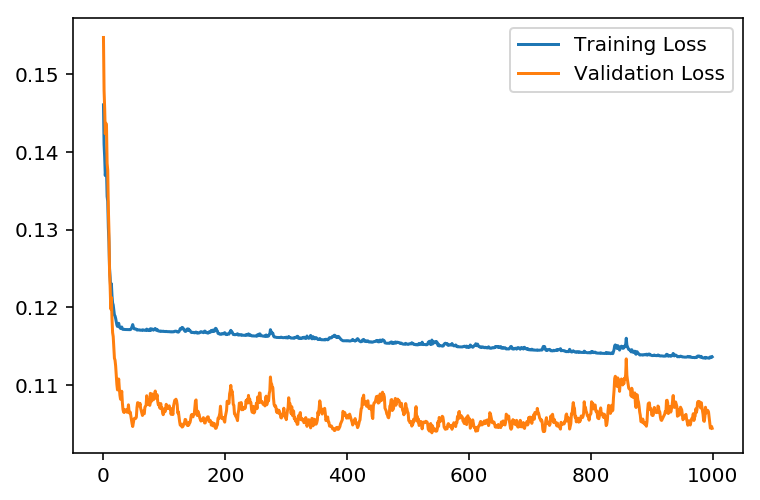

In [11]:
losses = { 'train':[], 'valid':[] }
for ii in range(epochs):
    batch = np.random.choice(train_features.index, size=20)
    x, y = train_features.ix[batch].values, train_targets.ix[batch]['class']
    
    # training
    network.train(x, y)
    
    # Validation
    mean_train_loss = network.evaluate(train_features.values, train_targets.values)
    losses['train'].append(mean_train_loss)
    
    mean_valid_loss = network.evaluate(val_features.values, val_targets.values)
    losses['valid'].append(mean_valid_loss)
    
    if ii % check_at == 0:
        print(
            "Epochs: {}/{}".format(ii, epochs) \
            + "... Progress: {}%".format(100 * ii/float(epochs)) \
            + "... Train Loss: {:2.2f}".format(mean_train_loss) \
            + "... Validation Loss: {:2.2f}".format(mean_valid_loss)
        )
    
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['valid'], label='Validation Loss')
plt.legend()
_ = plt.ylim()

## Testing
Evaluate the network model performance on the test data

In [12]:
mean_test_loss = network.evaluate(test_features.values, test_targets.values)
print("Test Loss: {}".format(mean_test_loss))

Test Loss: 0.11279147873291491
